# Лабораторная работа 1

# Ранжирование вопросов StackOverflow с помощью векторных представлений слов

### Бобряков А.С.

## Введение

В этом задании вы научитесь вычислять близость текстов и применить этот метод для поиска похожих вопросов на [StackOverflow](https://stackoverflow.com).

### Используемые библиотеки

В данном задании потребуются следующие библиотеки:
- [Gensim](https://radimrehurek.com/gensim/) — инструмент для решения различных задач NLP (тематическое моделирование, представление текстов, ...).
- [Numpy](http://www.numpy.org) — библиотека для научных вычислений.
- [scikit-learn](http://scikit-learn.org/stable/index.html) — библилиотека с многими реализованными алгоритмами машинного обучения для анализа данных.
- [Nltk](http://www.nltk.org) — инструмент для работы с естественными языками.


### Данные

Данные лежат в архиве `StackOverflowData.zip`, который состоит из:
- `train.tsv` - обучающая выборка. В каждой строке через табуляцию записаны дублирующие друг друга предложения;
- `test.tsv` - тестовая выборка. В каждой строке через табуляцию записаны: *<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...*

Скачать архив можно здесь: [ссылка на google диск](https://drive.google.com/open?id=1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_)

### Вектора слов

Для решения вам потребуются предобученная модель векторных представлений слов. Используйте [модель эмбеддингов](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit), которая была обучена с помощью пакета word2vec на данных Google News (100 миллиардов слов). Модель содержит 300-мерные вектора для 3 миллионов слов и фраз. Вы можете скачать их, запустив блок кода ниже.

In [ ]:
# Download Google vectors to directory *target_dir*

from download_utils import download_google_vectors
download_google_vectors(target_dir='.')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Часть 1. Предобученные векторные представления слов (2 балла)

Скачайте предобученные вектора и загрузите их с помощью функции [KeyedVectors.load_word2vec_format](https://radimrehurek.com/gensim/models/keyedvectors.html) библиотеки Gensim с параметром *binary=True*. Если суммарный размер векторов больше, чем доступная память, то вы можете загрузите только часть векторов, указав параметр *limit* (рекомендуемое значение: 500000).

In [ ]:
import gensim

In [ ]:
wv_embeddings = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/Texts_2020/GoogleNews-vectors-negative300.bin', binary = True, limit = 500000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Как пользоваться этими векторами?

Как только вы загрузите векторные представления слов в память, убедитесь, что имеете к ним доступ. Сначала вы можете проверить, содержится ли какое-то слово в загруженных эмбедингах:

    'word' in wv_embeddings

Затем, чтобы получить соответствующий вектор, вы можете использовать оператор доступа по ключу:

    wv_embeddings['word']

### Проверим, корректны ли векторные представления

Чтобы предотвратить возможные ошибки во время первого этапа, можно проверить, что загруженные вектора корректны. Для этого вы можете запустить функцию *check_embeddings*. Она запускает 3 теста:
1. Находит наиболее похожие слова для заданных "положительных" и "отрицательных" слов.
2. Находит, какое слово из заданного списка не встречается с остальными.
3. Находит наиболее похожее слово для заданного.

In [ ]:
import numpy as np


def check_embeddings(embeddings):
    error_text = "Something wrong with your embeddings ('%s test isn't correct)."
    most_similar = embeddings.most_similar(positive=['woman', 'king'], negative=['man'])
    if len(most_similar) < 1 or most_similar[0][0] != 'queen':
        return error_text % "Most similar"

    doesnt_match = embeddings.doesnt_match(['breakfast', 'cereal', 'dinner', 'lunch'])
    if doesnt_match != 'cereal':
        return error_text % "Doesn't match"

    most_similar_to_given = embeddings.most_similar_to_given('music', ['water', 'sound', 'backpack', 'mouse'])
    if most_similar_to_given != 'sound':
        return error_text % "Most similar to given"

    return "These embeddings look good."

def question_to_vec_tests(question_to_vec, wv_embeddings):
    if (np.zeros(300) != question_to_vec('', wv_embeddings)).any():
        return "You need to return zero vector for empty question."
    if (np.zeros(300) != question_to_vec('thereisnosuchword', wv_embeddings)).any():
        return "You need to return zero vector for the question, which consists only unknown words."
    if (wv_embeddings['word'] != question_to_vec('word', wv_embeddings)).any():
        return "You need to check the corectness of your function."
    if ((wv_embeddings['I'] + wv_embeddings['am']) / 2 != question_to_vec('I am', wv_embeddings)).any():
        return "Your function should calculate a mean of word vectors."
    if (wv_embeddings['word'] != question_to_vec('thereisnosuchword word', wv_embeddings)).any():
        return "You should not consider words which embeddings are unknown."
    return "Basic tests are passed."

def test_hits(hits_count):
    # *Evaluation example*
    # answers — dup_i
    answers = ["How does the catch keyword determine the type of exception that was thrown"]

    # candidates_ranking — the ranked sentences provided by our model
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown",
                           "NSLog array description not memory address",
                           "PECL_HTTP not recognised php ubuntu"]]
    # dup_ranks — position of the dup_i in the list of ranks +1
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]

    # correct_answers — the expected values of the result for each k from 1 to 4
    correct_answers = [0, 1, 1, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function."

    # Other tests
    answers = ["How does the catch keyword determine the type of exception that was thrown",
               "Convert Google results object (pure js) to Python object"]

    # The first test: both duplicates on the first position in ranked list
    candidates_ranking = [["How does the catch keyword determine the type of exception that was thrown",
                           "How Can I Make These Links Rotate in PHP"],
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [1, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function (test: both duplicates on the first position in ranked list)."

    # The second test: one candidate on the first position, another — on the second
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown"],
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0.5, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function (test: one candidate on the first position, another — on the second)."

    # The third test: both candidates on the second position
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown"],
                          ["WPF- How to update the changes in list item of a list",
                           "Convert Google results object (pure js) to Python object"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function (test: both candidates on the second position)."

    return "Basic test are passed."

def test_dcg(dcg_score):
    # *Evaluation example*
    # answers — dup_i
    answers = ["How does the catch keyword determine the type of exception that was thrown"]

    # candidates_ranking — the ranked sentences provided by our model
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown",
                           "NSLog array description not memory address",
                           "PECL_HTTP not recognised php ubuntu"]]
    # dup_ranks — position of the dup_i in the list of ranks +1
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]

    # correct_answers — the expected values of the result for each k from 1 to 4
    correct_answers = [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function."

    # Other tests
    answers = ["How does the catch keyword determine the type of exception that was thrown",
               "Convert Google results object (pure js) to Python object"]

    # The first test: both duplicates on the first position in ranked list
    candidates_ranking = [["How does the catch keyword determine the type of exception that was thrown",
                           "How Can I Make These Links Rotate in PHP"],
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [1, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function (test: both duplicates on the first position in ranked list)."

    # The second test: one candidate on the first position, another — on the second
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown"],
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0.5, (1 + (1 / (np.log2(3)))) / 2]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function (test: one candidate on the first position, another — on the second)."

    # The third test: both candidates on the second position
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown"],
                          ["WPF- How to update the changes in list item of a list",
                           "Convert Google results object (pure js) to Python object"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0, 1 / (np.log2(3))]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function (test: both candidates on the second position)."

    return "Basic test are passed."

def test_rank_candidates(rank_candidates, wv_embeddings):
    questions = ['converting string to list', 'Sending array via Ajax fails']
    candidates = [['Convert Google results object (pure js) to Python object',
                   'C# create cookie from string and send it',
                   'How to use jQuery AJAX for an outside domain?'],
                  ['Getting all list items of an unordered list in PHP',
                   'WPF- How to update the changes in list item of a list',
                   'select2 not displaying search results']]
    results = [[(1, 'C# create cookie from string and send it'),
                (0, 'Convert Google results object (pure js) to Python object'),
                (2, 'How to use jQuery AJAX for an outside domain?')],
               [(0, 'Getting all list items of an unordered list in PHP'),
                (2, 'select2 not displaying search results'),
                (1, 'WPF- How to update the changes in list item of a list')]]
    for question, q_candidates, result in zip(questions, candidates, results):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, 300)
        if not np.all(ranks == result):
            return "Check the function."
    return "Basic tests are passed."

In [ ]:
print(check_embeddings(wv_embeddings))

These embeddings look good.


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


### Векторные представления текста

Чтобы перейти от отдельных слов к векторным представлениям вопросов, предлагается подсчитать **среднее** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектоора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор. 

In [ ]:
import numpy as np

In [ ]:
def question_to_vec_by_mean(question, embeddings, dim=300):
    """
        question: a string
        embeddings: dict where the key is a word and a value is its' embedding
        dim: size of the representation

        result: vector representation for the question
    """
    words = [i for i in question.split() if i in embeddings]
    if words:
        return sum(embeddings[words]) / len(words)
    else:
        return np.zeros(dim)

Для базовой проверки решения запустите клетку ниже.

In [ ]:
print(question_to_vec_tests(question_to_vec_by_mean, wv_embeddings))

Basic tests are passed.


Теперь у нас есть метод для создания векторного представления любого предложения. Оценим, как будет работать это решение.

### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями. 

Сгенерируем для каждого из *N* вопросов *R* случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели *R + 1* примеров и смотреть на позицию дубликата.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то *K*:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [dup_i \in topK(q_i)],$$
где $q_i$ - $i$-ый вопрос, $dup_i$ - его дубликат, $topK(q_i)$ - первые *K* элементов в ранжированном списке, который выдает наша модель.

#### DCG@K
Второй метрикой будет упрощенная [DCG метрика](https://en.wikipedia.org/wiki/Discounted_cumulative_gain):
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank_{dup_i})}\cdot[rank_{dup_i} \le K],$$
где $rank_{dup_i}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$. С такой метрикой модель штрафуется за низкую позицию корректного ответа.

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера. Пусть $N = 1$, $R = 3$, вопрос $q_1$ это "Что такое python", а его дубликат $dup_1$ это "Что такое язык python". Пусть модель выдала следующий ранжированный список кандидатов:

1. *"Как узнать с++"*
2. *"Что такое язык python"*
3. *"Хочу учить Java"*
4. *"Не понимаю Tensorflow"*

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [dup_1 \in top1(q_1)] = 0$
- [K = 4] $\text{Hits@4} =  [dup_1 \in top4(q_1)] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

**<font color='red'>Задание. Реализуйте функции *hits_count* и *dcg_score*. </font>**

Каждая функция имеет два аргумента: *dup_ranks* и *k*. *dup_ranks* является списком, который содржит *рейтинги дубликатов* (их позиции в ранжированном списке). Например, *dup_ranks = [2]* для примера, описанного выше.

In [ ]:
# ембединг по косинусной мере входить в топ по метрикам выше
# метрика - hits - Ранжирует лементы . Есть предложения которые по косинусной мере topK() ембединги других предложений
# задача - обучить ембединги

def hits_count(dup_ranks, k):
    """
        dup_ranks: list of ranks of the duplicates; one rank per question; 
                   length is a number of questions that we check (N); 
                   rank is a number from 1 to len(candidates for the question).
        k: number of top-ranked elements (k in Hits@k metric)

        result: return Hits@k value for the current ranking.
    """
    return len([0 for i in dup_ranks if i <= k]) / len(dup_ranks)

In [ ]:
def dcg_score(dup_ranks, k):
    """
        dup_ranks: list of ranks of the duplicates; one rank per question; 
                   length is a number of questions that we check (N); 
                   rank is a number from 1 to len(candidates for the question).
        k: number of top-ranked elements (k in DCG@k metric)

        result: return DCG@k value for the current ranking.
    """
    return sum([1/np.log2(1+i) for i in dup_ranks if i <= k]) / len(dup_ranks)

Протестируйте функции. Успешное прохождение базовых тестов еще не гарантирует корректности реализации!

In [ ]:
print(test_hits(hits_count))

Basic test are passed.


In [ ]:
print(test_dcg(dcg_score))

Basic test are passed.


### Ранжирование вопросов StackOverflow

Выборка уже разбита на обучающую и тестовую. Все файлы используют табуляцию в качестве разделителя, но они имеют разный формат:

- *обучающая* выборка (test.tsv) содержит похожие друг на друга предложения в каждой строке;
- *тестовая* выборка (validation.tsv) содержит в каждой строке: *вопрос, похожий вопрос, отрицательный пример 1, отрицательный пример 2, ...*

Считайте тестовую выборку для оценки качества текущего решения.

In [ ]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data

In [ ]:
validation = read_corpus('/content/drive/My Drive/Colab Notebooks/Texts_2020/data/validation.tsv')

<font color='red'>**Задание. Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния.**</font>
    
Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список *[(2, c), (0, a), (1, b)]*.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def rank_candidates(question, candidates, embeddings, dim=300):
    """
        question: a string
        candidates: a list of strings (candidates) which we want to rank
        embeddings: some embeddings
        dim: dimension of the current embeddings
        
        result: a list of pairs (initial position in the list, question)
    """
    def f(candidat):
        x = question_to_vec_by_mean(candidat, embeddings, dim)
        y = question_to_vec_by_mean(question, embeddings, dim)
        return cosine_similarity([x, y])[0][1]
    
    result = [(i, e) for i, e in enumerate(candidates)]
    return sorted(result, key = lambda x: f(x[1]), reverse = True)

Протестируйте работу функции на примерах ниже.

In [ ]:
print(test_rank_candidates(rank_candidates, wv_embeddings))

Basic tests are passed.


Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояний между векторами в случае неэффективной реализации может занимать до 10 минут, разумнее сделать векторную реализацию.

In [ ]:
from tqdm.notebook import tqdm
wv_ranking = []
for line in tqdm(validation):
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

In [ ]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.214 | Hits@   1: 0.214
DCG@   5: 0.266 | Hits@   5: 0.312
DCG@  10: 0.283 | Hits@  10: 0.366
DCG@ 100: 0.323 | Hits@ 100: 0.564
DCG@ 500: 0.356 | Hits@ 500: 0.821
DCG@1000: 0.375 | Hits@1000: 1.000


Если вы проделали все шаги правильно, то вы должны разочароваться полученными результатами. Давайте попробуем понять, почему качество модели такое низкое. Когда вы работаете с какими-либо данными, очень полезно первым делом посмотреть на них глазами. Выведите несколько вопросов из наших данных:

In [ ]:
for line in validation[:3]:
    q, *examples = line
    print(q, *examples[:3])
    print()

How to print a binary heap tree without recursion? How do you best convert a recursive function to an iterative one? How can i use ng-model with directive in angular js flash: drawing and erasing

How to start PhoneStateListener programmatically? PhoneStateListener and service Java cast object[] to model WCF and What does this mean?

jQuery: Show a div2 when mousenter over div1 is over when hover on div1 depenting on if it is on div2 or not it should act differently How to run selenium in google app engine/cloud? Python Comparing two lists of strings for similarities



### Предобработка текстов

Как вы могли заметить, мы имеем дело с сырыми данными. Это означает, что там присутствует много опечаток, спецсимволов и заглавных букв. В нашем случае это все может привести к ситуации, когда для данных токенов нет предобученных векторов. Поэтому необходима предобработка.

<font color='red'>**Задание. Реализуйте функцию предобработки текстов.**</font>

Вам требуется:
- Перевести символы в нижний регистр;
- Заменить символы пунктуации на пробелы;
- Удалить "плохие" символы;
- Удалить стопслова.

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def text_prepare(text):
    """
        text: a string
        
        return: modified string
    """
    for i in string.punctuation:
        text = text.replace(i, ' ')
    text = re.sub('[^a-z ]+', '', text.lower())
    words = text.split()
    sw = set(stopwords.words('english'))
    return ' '.join([i for i in words if i not in sw])

<font color='red'>**Задание. Теперь преобразуйте все вопросы из тестовой выборки. Оцените, как изменилось качество. Сделайте выводы.**</font>

In [ ]:
new_validation = validation.copy()
for i in tqdm(range(len(new_validation))):
    new_validation[i] = [text_prepare(j) for j in validation[i]]

In [ ]:
new_validation[0][0]

'print binary heap tree without recursion'

In [ ]:
from tqdm.notebook import tqdm
new_wv_ranking = []
for line in tqdm(new_validation):
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    new_wv_ranking.append([r[0] for r in ranks].index(0) + 1)

In [ ]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(new_wv_ranking, k), k, hits_count(new_wv_ranking, k)))

DCG@   1: 0.347 | Hits@   1: 0.347
DCG@   5: 0.419 | Hits@   5: 0.484
DCG@  10: 0.435 | Hits@  10: 0.532
DCG@ 100: 0.470 | Hits@ 100: 0.706
DCG@ 500: 0.489 | Hits@ 500: 0.858
DCG@1000: 0.504 | Hits@1000: 1.000


In [ ]:
print('Предобработка важна, так как качество улучшается на следующие величины:')
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(new_wv_ranking, k) - dcg_score(wv_ranking, k), k, hits_count(new_wv_ranking, k) - hits_count(wv_ranking, k)))

Предобработка важна, так как качество улучшается на следующие величины:
DCG@   1: 0.132 | Hits@   1: 0.132
DCG@   5: 0.153 | Hits@   5: 0.172
DCG@  10: 0.151 | Hits@  10: 0.166
DCG@ 100: 0.147 | Hits@ 100: 0.141
DCG@ 500: 0.134 | Hits@ 500: 0.038
DCG@1000: 0.130 | Hits@1000: 0.000


In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Texts_2020/after1.bin', 'wb') as fout:
    pickle.dump(new_validation, fout)


## Часть 2. Представления для неизвестных слов. (3 балла)

<font color='red'>**Задание. Оцените долю слов в выборке, для которых нет эмбеддинга в модели.**</font>

In [ ]:
known_words = set()
unknown_words = set()
for e in new_validation:
    for s in e:
        for w in s.split():
            if w in wv_embeddings:
                known_words.add(w)
            else:
                unknown_words.add(w)
print('Доля слов, для которых нет эмбеддингов равна', len(known_words) / (len(known_words) + len(unknown_words)))

Доля слов, для которых нет эмбеддингов равна 0.47433289457939454


In [ ]:
vocab = list(known_words)
vocab2id = {vocab[i]: i for i in range(len(vocab))}
all_words = list(known_words.union(unknown_words))

Для того, что получить представления для неизвестного слова, воспользуемся следующим подходом:
    
1. Будем восстанавливать эмбеддинг неизвестного слова как сумму эмбеддингов буквенных триграмм. Например, слово where должно представляться суммой триграмм _wh, whe, her, ere, re_

2. В качестве обучающих данных будем использовать слова, для которых есть эмбеддинг в модели. Будем обучать эмбеддинги триграмм по выборке эмбеддингов с помощью функционала MSE:

$$L = \sum_{w \in W_{known}}\| f_{\theta}(w) - v_w \|^2 \to \min_{\theta}$$

где:

* $W_{known}$ — множество известных модели слов
* $f_{\theta}(w)$ — сумма эмбеддингов триграмм слова $w$
* $v_w$ — эмбеддинг слова $w$
* $\theta$ — веса эмбеддингов триграмм

<font color='red'>**Задание. Реализуйте предложенную модель ниже.**</font>

Используйте класс nn.EmbeddingBag для построения среднего вектора представлений.

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam

In [ ]:
class TrigrammTokenizer:

    def __init__(self, words):
        trigramms = set()
        for w in words:
            trigramms.update(self.get_trigramms(w)) 
        self.trigramms = list(trigramms)
        self.trigramms2id = {self.trigramms[i]: i for i in range(len(self.trigramms))}

    @staticmethod
    def get_trigramms(word):
        result = []
        result.append(' ' + word[:2])
        for i in range(len(word) - 2):
            result.append(word[i:i+3])
        result.append(word[len(word)-2:] + ' ')
        return result

    def __call__(self, word):
        return [self.trigramms2id[t] for t in self.get_trigramms(word)]

In [ ]:
tri_tokenizer = TrigrammTokenizer(all_words)

In [ ]:
from torch.utils.data import Dataset

class TrigrammDataset(Dataset):

    def __init__(self, vocab, embeddings, tri_tokenizer):
        self.data = []
        for w in vocab:
            self.data.append((tri_tokenizer(w), embeddings[w]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
tri_dataset = TrigrammDataset(vocab, wv_embeddings, tri_tokenizer)

In [ ]:
from torch.utils.data import DataLoader
    
def tri_collate(batch):
    objects, targets = zip(*batch)
    indices = []
    shifts = torch.LongTensor(len(objects))
    s = 0
    for i, e in enumerate(objects):
        shifts[i] = s
        s += len(e)
        for j in e:
            indices.append(j)
    indices = torch.LongTensor(indices)
    targets = torch.FloatTensor(targets)
    return indices, shifts, targets

In [ ]:
tri_loader = DataLoader(tri_dataset, batch_size=256, shuffle=True, collate_fn=tri_collate)

In [ ]:
class TrigrammEmbeddingsModel(nn.Module):
    # есть словарь по датасету. Слово  = цифра
    # EmbeddingBag - понижает размерность -> новое векторное представление
    
#1. Кодируем слова цифрами
#2. Ембединг - векторное представление слова. Если словарь = миллиону слову, но уменьшается размерность
#3. Обучаемся чтобы  по векторному представлению слова можно было найти похожее предложение
# Если возьмем косинусноую меру от словаря -> плохо. А мы используем ембед

# 2. Вход = предложение (цифры слов) в EmbeddingBag
    def __init__(self, num_embeddings, embedding_dim=300):
        """
        all_known_tokens : list of str
        
        embedding_dim : int
        """
        super().__init__()  
        
        self.embedding_bag = nn.EmbeddingBag(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
        )
        
    def forward(self, indices, shifts):
        return self.embedding_bag(indices, shifts)  


<font color='red'>**Задание. Обучите модель. Оцените, как изменилось качество. Сделайте выводы.**</font>

Если вы всё реализовали правильно, качество решения должно вырасти.

In [ ]:
device = torch.device('cuda')

In [ ]:
model = TrigrammEmbeddingsModel(len(tri_tokenizer.trigramms)).to(device)
loss_function = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    # model.train()
    for i, (indices, shifts, targets) in enumerate(train_loader):
        indices = indices.to(device)
        shifts = shifts.to(device)
        targets = targets.to(device)
        
        outputs = model(indices, shifts)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [ ]:
all_losses = []
for epoch in tqdm(range(50)):
    loss = train_epoch(model, optimizer, tri_loader, loss_function, device)
    all_losses.append(loss)

In [ ]:
from matplotlib import pyplot as plt

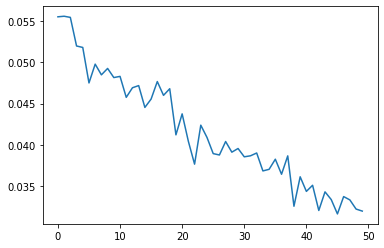

In [ ]:
plt.plot(all_losses)

In [ ]:
from copy import deepcopy
my_embeddings = deepcopy(wv_embeddings)

In [ ]:
with torch.no_grad():
    for w in tqdm(list(unknown_words)):
        indxs = torch.LongTensor(tri_tokenizer(w)).to(device)
        shfts = torch.LongTensor([0]).to(device)
        my_embeddings.add(w, model.forward(indxs, shfts).to('cpu').numpy().reshape(300)) 

In [ ]:
new_wv_ranking2 = []
for line in tqdm(new_validation):
    q, *ex = line
    ranks = rank_candidates(q, ex, my_embeddings)
    new_wv_ranking2.append([r[0] for r in ranks].index(0) + 1)

In [ ]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(new_wv_ranking2, k), k, hits_count(new_wv_ranking2, k)))

DCG@   1: 0.438 | Hits@   1: 0.438
DCG@   5: 0.511 | Hits@   5: 0.576
DCG@  10: 0.528 | Hits@  10: 0.627
DCG@ 100: 0.560 | Hits@ 100: 0.785
DCG@ 500: 0.577 | Hits@ 500: 0.920
DCG@1000: 0.586 | Hits@1000: 1.000


In [ ]:
print('Прирост качества после обучения:')
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(new_wv_ranking2, k) - dcg_score(new_wv_ranking, k), k, hits_count(new_wv_ranking2, k) - hits_count(new_wv_ranking, k)))

Прирост качества после обучения:
DCG@   1: 0.091 | Hits@   1: 0.091
DCG@   5: 0.092 | Hits@   5: 0.091
DCG@  10: 0.093 | Hits@  10: 0.095
DCG@ 100: 0.090 | Hits@ 100: 0.079
DCG@ 500: 0.088 | Hits@ 500: 0.062
DCG@1000: 0.081 | Hits@1000: 0.000


In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Texts_2020/after2.bin', 'wb') as fout:
    pickle.dump(my_embeddings, fout)

## Часть 3. Обучение метрики. (5 баллов)

Косинусное расстояние на фиксированных предобученных векторах - самое простое, но не самое лучшее решение. 
Качество можно улучшить, если обучить функцию близости для решения конкретной задачи.
    
В этом пункте вам предлагается обучить полносвязную нейронную сеть, предсказывающую близость пары вопросов в диапазоне от 0 до 1. Для этого предлагается использовать следующую нейронную сеть:

- вход: векторные представления пары вопросов (нескольких пар, если использовать обучение по батчам)
- выход: ненормированное число, показатель близости вопросов
- архитектура: сначала необходимо сагрегировать эмбеддинги пар (например, сконкатенировать), а затем применить несколько полносвязных слоёв (рекомендуется 2) с нелинейностями (например, `torch.nn.ReLU`)
- функция потерь: кросс-энтропия от сигмоиды выхода сети (рекомендуется использовать `torch.nn.BCELoss``)

Пример архитектуры показан на картинке ниже:
<img src="dssm_we_problem.png" alt="dssm"
	title="nn example" width="300" height="300" />


Чтобы учить такую модель, нужны как и положительные примеры (дубликаты вопросов), так и отрицательные (вопросы, которые не являются дубликатами). Важное значение имеет метод выбора отрицательных примеров. Самый базовый вариант - на каждую верную пару (s1, s2) случайно выбирать 5-10 случайных пар (s1, s).
Более сложная стратегия - использовать в качестве примеров чем-то похожие, но на самом деле не близкие пары вопросов (например, можно использовать для подбора примеров уже опробованный выше метод через косинусное расстояние).

Обучите нейросеть (на обучающих данных) и посчитайте с её помощью заданные метрики на тестовых данных. Оценка за этот пункт будет зависеть от итоговых значений метрики (ожидается значение Hits@ 1 не менее 0.53). Для того, чтобы добиться этого, можно воспользоваться следующими идеями:
- для обучения сети достаточно 5-12 эпох
- для такого рода задач хорошей агрегацией входных векторов u и v является конкатенированный вектор \[u, v, u - v, u * v\], где все операции поэлементные
- если 2 слоя вам мало, попробуйте 3-5 и различное число нейронов
- исходные векторные представления можно дообучать, можно делать это сразу, но лучше сперва заморозить их веса, а затем разморозить после нескольких эпох

- больший объём обучающих данных может ощутимо повысить качество
- ещё качество обычно растёт при правильном использовании регуляризации (например, `torch.nn.Dropout`, `torch.nn.BatchNorm1D`)

__За задание можно получить до 2 бонусных баллов, если значение Hits@ 1 превысит на валидации 0.55 (балл будет зависитеть от величины превышения).__

<font color='red'>**Опишите модель и функцию генерации примеров. Обучите модель, оцените, как изменилось качество. Сделайте выводы.**</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pickle

with open('/content/drive/My Drive/Colab Notebooks/Texts_2020/after1.bin', 'rb') as fin:
    new_validation = pickle.load(fin)

with open('/content/drive/My Drive/Colab Notebooks/Texts_2020/after2.bin', 'rb') as fin:
    my_embeddings = pickle.load(fin)

In [ ]:
train_full = read_corpus('/content/drive/My Drive/Colab Notebooks/Texts_2020/data/train.tsv')

In [ ]:
train = train_full[:500000]

In [ ]:
from tqdm.notebook import tqdm

new_train = train.copy()
for i in tqdm(range(len(new_train))):
    new_train[i] = [text_prepare(j) for j in train[i]]

In [ ]:
from torch.utils.data import Dataset

class MetricDataset(Dataset):

    def __init__(self, couples, embeddings, k=20, dim=300):
        self.k = k
        self.couples = couples
        self.data = [0 for _ in range(len(couples)*(k+1))]
        self.flag = len(self.data)
        for i, c in enumerate(couples):
            s1 = torch.FloatTensor(question_to_vec_by_mean(c[0], embeddings, dim))
            self.data[i] = [s1, torch.FloatTensor(question_to_vec_by_mean(c[1], embeddings, dim))]
            for j in range(k*i+len(couples), k*(i+1)+len(couples)):
                self.data[j] = [s1, 0]
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        lc = len(self.couples)
        if self.flag % self.__len__() == 0:
            self.flag = 0
            s_list = np.random.randint(1, lc - self.k, size=lc)
            for i, s in enumerate(s_list):
                for j in range(self.k):
                    self.data[lc+i*self.k+j][1] = self.data[(i+s+j)%lc][0]
        self.flag += 1
        a = self.data[idx][0]
        b = self.data[idx][1]
        return torch.cat((a, b, a-b, a*b)), torch.FloatTensor([1 if idx < lc else 0]) 


In [ ]:
dataset = MetricDataset(train, my_embeddings, k=10)

In [ ]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [ ]:
class MetricModel(nn.Module):
    
    def __init__(self, dim=300):
        super().__init__()
        self.dim = dim
        self.linear1 = nn.Linear(dim*4, dim)
        self.bn = nn.BatchNorm1d(dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(dim, 1)

    def forward(self, x):
        out = self.relu(self.bn(self.linear1(x)))
        return self.linear2(out)        


In [ ]:
device = torch.device('cuda')

In [ ]:
model = MetricModel().to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-6)

In [ ]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    model.train()
    for objects, targets in train_loader:        
        objects = objects.to(device)
        targets = targets.to(device)

        outputs = model(objects)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [ ]:
all_losses = []
for epoch in tqdm(range(5)):
    loss = train_epoch(model, optimizer, loader, loss_function, device)
    all_losses.append(loss)

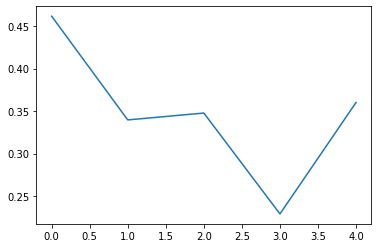

In [ ]:
from matplotlib import pyplot as plt

plt.plot(all_losses)

In [ ]:
def rank_candidates2(question, candidates, embeddings, model, device, dim=300):
    """
        question: a string
        candidates: a list of strings (candidates) which we want to rank
        embeddings: some embeddings
        dim: dimension of the current embeddings
        
        result: a list of pairs (initial position in the list, question)
    """
    def f(candidat):
        with torch.no_grad():
            x = question_to_vec_by_mean(candidat, embeddings, dim)
            y = question_to_vec_by_mean(question, embeddings, dim)
            x = torch.FloatTensor(x)
            y = torch.FloatTensor(y)
            v = torch.cat((x, y, x-y, x*y)).view(1, -1).to(device)
            return torch.sigmoid(model(v)).to('cpu')
    
    result = [(i, e) for i, e in enumerate(candidates)]
    return sorted(result, key = lambda x: f(x[1]), reverse = True)

In [86]:
model.eval()
new_wv_ranking3 = []
for line in tqdm(new_validation):
    q, *ex = line
    ranks = rank_candidates2(q, ex, my_embeddings, model, device)
    new_wv_ranking3.append([r[0] for r in ranks].index(0) + 1)

In [87]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(new_wv_ranking3, k), k, hits_count(new_wv_ranking3, k)))

DCG@   1: 0.376 | Hits@   1: 0.376
DCG@   5: 0.465 | Hits@   5: 0.542
DCG@  10: 0.483 | Hits@  10: 0.598
DCG@ 100: 0.520 | Hits@ 100: 0.777
DCG@ 500: 0.539 | Hits@ 500: 0.928
DCG@1000: 0.547 | Hits@1000: 1.000
